# Using Custom Callbacks When Running TARDIS

The function `run_tardis` allows users to provide a set of callbacks to the simulation. These callbacks are functions that will be run at the end of each iteration, and can do a variety of things, such as printing information about the simulation, storing data to a table, or even changing simulation parameters between iterations. This tutorial will show three examples of callbacks and how they can be used in TARDIS. One important thing to note is that the first argument of the callback must be the `Simulation` object being run.

Our first callback example will compute the (volume-weighted) average radiative temperature in the supernova ejecta (outside of the photosphere) and will print its value:

In [1]:
def average_temp(sim):
    t_rads = sim.simulation_state.t_radiative
    volumes = sim.simulation_state.volume
    avg = sum(t_rads*volumes) / sum(volumes)
    print(f"Average temperature for iteration {sim.iterations_executed}: {avg}")

Now we give the callback to `run_tardis`.  `run_tardis` offers the keyword argument `simulation_callbacks` which takes a list of lists containing the callback as well as any optional arguments you wish to include with your callback.  For this example our function requires no extra arguments and we only have a single callback, so we give `run_tardis` a 2D list containing the callback as its only element:

In [2]:
# We filter out warnings in this notebook
import warnings
warnings.filterwarnings('ignore')

from tardis import run_tardis
from tardis.io.atom_data import download_atom_data

# We download the atomic data needed to run the simulation
download_atom_data('kurucz_cd23_chianti_H_He')

# We run the simulation with our callback
sim = run_tardis('tardis_example.yml', 
                 simulation_callbacks=[[average_temp]])

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Atomic Data kurucz_cd23_chianti_H_He already exists in /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5. Will not download - override with force_download=True.


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

Average temperature for iteration 1: 10001.603411107712 K


Average temperature for iteration 2: 10641.477669409178 K


Average temperature for iteration 3: 10792.760201013944 K


Average temperature for iteration 4: 10846.759145528567 K


Average temperature for iteration 5: 10848.990163319238 K


Average temperature for iteration 6: 10831.883798189623 K


Average temperature for iteration 7: 10897.704473827027 K


Average temperature for iteration 8: 10900.290807756717 K


Average temperature for iteration 9: 10956.101488012848 K


Average temperature for iteration 10: 10869.148338893856 K


Average temperature for iteration 11: 10850.71192892092 K


Average temperature for iteration 12: 10936.97456774537 K


Average temperature for iteration 13: 10929.044876814343 K


Average temperature for iteration 14: 10822.397946931736 K


Average temperature for iteration 15: 10858.624696299064 K


Average temperature for iteration 16: 10921.304592045632 K


Average temperature for iteration 17: 10967.405875386541 K


Average temperature for iteration 18: 10928.81349527043 K


Average temperature for iteration 19: 10919.657818380307 K


Average temperature for iteration 20: 10919.657818380307 K


## Running Callbacks with Extra Arguments

The callbacks provided to `run_tardis` can also take extra arguments. As an example, we'll make a callback that appends the number of monte carlo packets emitted by the supernova for each iteration to a list so we can plot the number of emitted packets for each iteration. We will also specify that we want this information for all but the last iteration, as more packets are used in the last iteration than are used in the other iterations. The callback will take a list we want to append to as an argument. We'll send both this new callback and our original `average_temp` callback to `run_tardis` as an example of using multiple callbacks at once:

In [3]:
def append_num_emitted_to_list(sim, lst):
    if sim.iterations_executed < sim.iterations:
        num_emitted_packets = len(sim.transport.transport_state.emitted_packet_nu)
        lst.append(num_emitted_packets)

In order to add our new callback, we just create another entry in our list of callbacks. Since `append_num_emitted_to_list` takes an extra argument, we will provide that argument in the inner list containing the callback:

In [4]:
# Initialize a list to store the number of emitted packets
num_emitted_list = []

# Make our list of callbacks
callbacks = [[average_temp], 
             [append_num_emitted_to_list, num_emitted_list]]

# Run the simulation with both of our callbacks
sim = run_tardis('tardis_example.yml', 
                 simulation_callbacks=callbacks)

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

Average temperature for iteration 1: 10001.603411107712 K


Average temperature for iteration 2: 10641.477669409178 K


Average temperature for iteration 3: 10792.760201013944 K


Average temperature for iteration 4: 10846.759145528567 K


Average temperature for iteration 5: 10848.990163319238 K


Average temperature for iteration 6: 10831.883798189623 K


Average temperature for iteration 7: 10897.704473827027 K


Average temperature for iteration 8: 10900.290807756717 K


Average temperature for iteration 9: 10956.101488012848 K


Average temperature for iteration 10: 10869.148338893856 K


Average temperature for iteration 11: 10850.71192892092 K


Average temperature for iteration 12: 10936.97456774537 K


Average temperature for iteration 13: 10929.044876814343 K


Average temperature for iteration 14: 10822.397946931736 K


Average temperature for iteration 15: 10858.624696299064 K


Average temperature for iteration 16: 10921.304592045632 K


Average temperature for iteration 17: 10967.405875386541 K


Average temperature for iteration 18: 10928.81349527043 K


Average temperature for iteration 19: 10919.657818380307 K


Average temperature for iteration 20: 10919.657818380307 K


Now we can look at how many packets are emitted after each iteration:

Text(0, 0.5, 'Number of emitted packets')

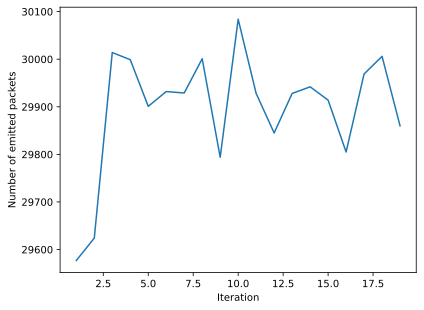

In [5]:
import matplotlib.pyplot as plt

# Generate a list of each iteration number for the x-axis
iterations = list(range(1, len(num_emitted_list)+1))

# Plot the number of emitted packets
plt.plot(iterations, num_emitted_list)
plt.xlabel("Iteration")
plt.ylabel("Number of emitted packets")

## Using Callbacks to Add New Functionality

Callbacks can also add new functionality to the code. For example, we introduce one final callback `inc_packets` that will increase the number of packets in the following iteration by a number $N$ (which is an argument to the callback, in our example we shall use $N=1000$):

In [6]:
def inc_packets(sim, N):
    sim.no_of_packets += N

In [7]:
# Initialize a new list to store the number of emitted packets
num_emitted_list_new = []

# Make our new list of callbacks
callbacks = [[average_temp],
             [append_num_emitted_to_list, num_emitted_list_new], 
             [inc_packets, 1000]]

# Run the simulation with all three of our callbacks
sim = run_tardis('tardis_example.yml', 
                 simulation_callbacks=callbacks)

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

Average temperature for iteration 1: 10001.603411107712 K


Average temperature for iteration 2: 10634.139794382323 K


Average temperature for iteration 3: 10833.398494456378 K


Average temperature for iteration 4: 10832.305454328614 K


Average temperature for iteration 5: 10790.514774537485 K


Average temperature for iteration 6: 10824.883036182136 K


Average temperature for iteration 7: 10795.962444544772 K


Average temperature for iteration 8: 10847.776242022315 K


Average temperature for iteration 9: 10958.786611966521 K


Average temperature for iteration 10: 10952.445403643205 K


Average temperature for iteration 11: 10913.480246054864 K


Average temperature for iteration 12: 10924.633299699559 K


Average temperature for iteration 13: 10912.659580243939 K


Average temperature for iteration 14: 10917.964286659973 K


Average temperature for iteration 15: 10927.487044268359 K


Average temperature for iteration 16: 10912.477296044011 K


Average temperature for iteration 17: 10875.388221054549 K


Average temperature for iteration 18: 10880.38765830457 K


Average temperature for iteration 19: 10917.541296277599 K


Average temperature for iteration 20: 10917.541296277599 K


Now, let's see how this affected our plot for packets emitted in each iteration:

Text(0, 0.5, 'Number of emitted packets')

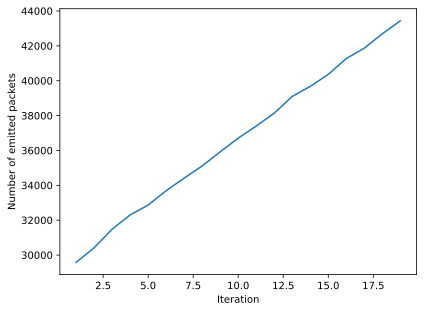

In [8]:
plt.plot(iterations, num_emitted_list_new)
plt.xlabel("Iteration")
plt.ylabel("Number of emitted packets")

As expected, the number of packets emitted will keep on increasing as 1000 more packets are run each iteration.